# OOD Detection Pipeline

## 1. Load data to obtain hidden representations.

### Datasets

In [10]:
from constants.data_constants import JORDAN_DATASET_FILEPATH, MAESTRO_DATASET_FILEPATH
from data.jordan_dataset import JordanDataset
from data.maestro_dataset import MaestroDataset


print("Loading Jordan dataset - train")
id_train_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train",
    name="id_train_dataset"
)
print(f"Obtained {len(id_train_dataset)} training examples from Jordan dataset - train")

print("Loading Jordan dataset - test")
id_test_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation",
    name="id_test_dataset"
)
print(f"Obtained {len(id_test_dataset)} testing examples from Jordan dataset - test")

print("Loading Maestro dataset - test")
ood_dataset = MaestroDataset(
    data_dir=MAESTRO_DATASET_FILEPATH,
    split="test",
    name="maestro_test_dataset"
)
print(f"Obtained {len(ood_dataset)} testing examples from Maestro dataset - test")

Loading Jordan dataset - train
Loading train split from /scratch/joel/jordan_dataset...
Loaded 4060 samples from train split
Sample keys: ['input_ids', 'labels']
Skipped 490 bad samples
Obtained 4060 training examples from Jordan dataset - train
Loading Jordan dataset - test
Loading validation split from /scratch/joel/jordan_dataset...
Loaded 84 samples from validation split
Sample keys: ['input_ids', 'labels']
Skipped 0 bad samples
Obtained 84 testing examples from Jordan dataset - test
Loading Maestro dataset - test
path /scratch/joel/maestrodata/test.txt
Obtained 962 testing examples from Maestro dataset - test


### DataLoaders

In [11]:
from torch.utils.data import DataLoader
from utils.data_loading import collate_fn

batch_size = 8

id_train_dataloader = DataLoader(id_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
id_test_dataloader = DataLoader(id_test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
ood_dataloader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


### Model

In [12]:
from constants.model_constants import DEVICE, JORDAN_MODEL_NAME
import torch
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    JORDAN_MODEL_NAME,
    dtype=torch.float32,
).to(DEVICE)

# 2. OOD Detector

Refer to [OOD detection docs](../../docs/ood_detection.md) for more information about this.

In [13]:
from main.transformation_functions import extract_layer_with_mean_std_pooling
from main.transformations import Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from main.scoring_functions import mahalanobis_distance

transformations = Transformations(
    [
        extract_layer_with_mean_std_pooling(model, [12]),
        PCA(n_components=10),
        StandardScaler(),
    ]
) # this is IN ADDITION to the extraction done in extract_layers.py
scoring_function = mahalanobis_distance

## Create OOD detector
from transformations and scoring function

In [14]:
from main.ood_detector import OODDetector

ood_detector = OODDetector(
    embedding_function=transformations,
    scoring_function=scoring_function,
    id_train_data=id_train_dataloader,
)

Extracting representations from id_train_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028,

We can evaluate the detector!

```threshold = 0.7``` with ```threshold_type = "percentile"``` means that the score threshold is set to be the 70th percentile of all the scores (ID test + OOD test combined).

In [15]:
confusion_matrix, true_positive_rate, false_positive_rate = ood_detector.evaluate(
    id_test_dataloader,
    ood_dataloader,
    threshold=0.7,
    threshold_type="percentile",
)
print("Confusion matrix:", confusion_matrix)
print("True positive rate:", true_positive_rate)
print("False positive rate:", false_positive_rate)


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

We can plot the ROC curve and get AUROC!

AUROC will appear as ```main/auroc.png```

Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


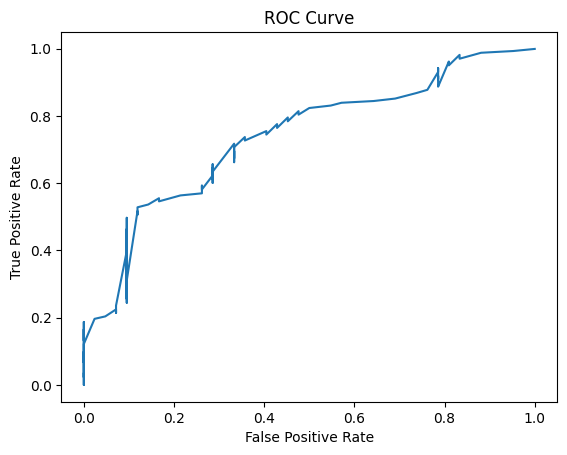

In [16]:
from eval.auroc import get_auroc

auroc = get_auroc(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

THIS IS SO SUS i think it needs to be debugged...

In [17]:
print("AUROC:", auroc)



AUROC: 0.7368082404136658
